# Импорт модулей

In [ ]:
!pip install dostoevsky
!pip install stop_words
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393184 sha256=3399808d85c8f0813d3756308ff29c8f04f4727a4198cd94a7198625a35b58ad
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext
  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32897 sha256=1d12b6e1e21023cb9da52fe3d28dc02f30edb4f68960fdfe49b826d24c132c9d
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 56.8 MB/s eta 0:00:00
  Preparing metadata

In [ ]:
!python -m dostoevsky download fasttext-social-network-model

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import stop_words
import pymorphy2
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from PIL import Image
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
import nltk

nltk.download('punkt')

tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Загрузка данных

In [ ]:
path = 'drive/MyDrive/datasets/Chat_data/'

with open(path+'data_drive_club.json', 'r') as f:
  file = json.load(f)

data = list()

for message in file['messages']:
  date = message['date']
  text = message['text']
  ix = message['id']
  try:
    user = message['actor']
  except:
    user = message['from']
  data.append([ix, date,text,user])

df = pd.DataFrame(data, columns = ['id', 'date', 'text', 'user'])
df.date = pd.to_datetime(df.date)
df.set_index('id', inplace = True)

In [ ]:
df.head(15)

,date,text,user
id,,,
-999874151,2023-05-06 23:26:23,,Данила
-999874150,2023-05-06 23:27:35,,Данила
-999874145,2023-05-07 09:15:41,,Данила
-999874144,2023-05-07 09:15:41,,Данила
-999874142,2023-05-07 09:16:09,,Данила
-999874141,2023-05-07 09:16:31,,Данила
-999874139,2023-05-07 09:18:34,,Данила
-999874135,2023-05-07 09:22:25,"[Тем, кому интересна тема теории вероятностей,...",Данила
-999874126,2023-05-07 12:42:02,,Данила


# Обучение модели

Отберем только те сообщения, которые имеют длину более 4 слов

In [ ]:
msgs = df.text.apply(lambda x: x if type(x) == str and len(x.split()) > 4 else None).dropna()
df_sentiment = df[df.index.isin(msgs.index)]

df_sentiment.head()

,date,text,user
id,,,
-999874125,2023-05-07 12:55:46,"Еще раз всем привет🔥\n\nЭта беседа нужна, чтоб...",Данила
-999874124,2023-05-07 12:56:35,Сейчас я занят подготовкой курса по data scien...,Данила
-999873962,2023-05-08 00:09:52,"Книга для тех, кто решил погрузится в статисти...",Данила
-999873715,2023-05-10 21:14:12,Кто-нибудь сидит на код-варсе? Хотел предложит...,zub
-999873625,2023-05-10 22:13:39,там можно баттл устраивать?) \n\nя там сидел п...,Данила


In [ ]:
sentiments = model.predict(df_sentiment.text.to_list())
df_sent = pd.DataFrame(sentiments, index = msgs.index)
df_sentiment = df_sentiment.join(df_sent)

In [ ]:
df_sentiment.head()

,date,text,user,neutral,negative,skip,positive,speech
id,,,,,,,,
-999874125,2023-05-07 12:55:46,"Еще раз всем привет🔥\n\nЭта беседа нужна, чтоб...",Данила,0.600198,0.245095,0.103759,0.058356,0.013233
-999874124,2023-05-07 12:56:35,Сейчас я занят подготовкой курса по data scien...,Данила,0.754925,0.206904,0.067557,0.075868,0.003955
-999873962,2023-05-08 00:09:52,"Книга для тех, кто решил погрузится в статисти...",Данила,0.622469,0.239359,0.053413,0.112805,0.015435
-999873715,2023-05-10 21:14:12,Кто-нибудь сидит на код-варсе? Хотел предложит...,zub,0.731069,0.050341,0.334599,0.010338,0.001109
-999873625,2023-05-10 22:13:39,там можно баттл устраивать?) \n\nя там сидел п...,Данила,0.615098,0.033096,0.060097,0.085109,0.002333


# EDA

## Топ комментаторов

In [ ]:
top_15 = df.groupby('user')\
           .agg({'text':'count'})\
           .sort_values('text', ascending = False)\
           .head(15)

anti_top_15 = df.groupby('user')\
           .agg({'text':'count'})\
           .sort_values('text', ascending = False)\
           .tail(15)

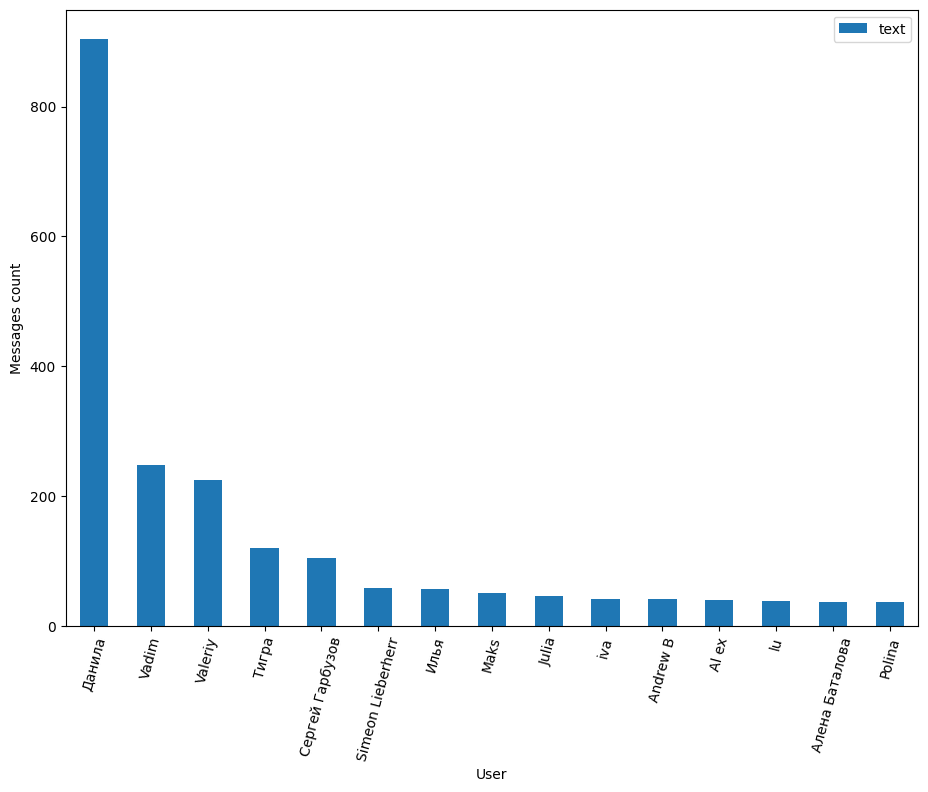

In [ ]:
top_15.plot(kind='bar', figsize = (11, 8))

plt.xticks(rotation = 75)
plt.xlabel('User')
plt.ylabel('Messages count')

plt.show()

## Топ негативных сообщений

In [ ]:
for text in df_sentiment.sort_values('negative', ascending = False).iloc[:40].text:
  print(text, end = '\n\n')

наш чат не про хтмл :(

Это не совсем красиво описал ((( но да они сказали, немного по другому ...

Ястребиные больше поддаются дрессуре, их используют в патруле аэропортов, ну и в соколиной охоте.Совы ненавидят всех и все)

У меня какая-то проблема со звуком в этом видео. Данила, там совсем не слышно тебя(

Ну да, новая страна, почему бы не организовать его.

Да, без проблем, но только завтра утром

точнее сложно сказать, потому что нет опыта.

Вообще надо спать идти. Завтра надо разгребать материал. Тут чёт годноты поскидывали

Ну вот блин( а я хотел в Питере остаться..

Ноотропы я тоже ни ни

Плин, дак ведь крутые пропорции, как так то((

ну сетку тоже не балды джун будет делать. сам убеждался разные оптимизаторы работают по разному, и  бывало такое что простая сетка работала лучше чем сложная

Попалась инфа. Эта функция меня реально выручает в процессе дебага

Коленки не заводите за ступни, чтобы коленки не портить👍

Вообще, я хотела просто собаку( Не срослось, не потяну по времени

## Визуализация тональности во времени

In [ ]:
df_sentiment_day_resample = df_sentiment.set_index('date')\
                    .resample('D')\
                    .agg({
                          'text':'count',
                          'negative':'mean',
                          'positive':'mean'
                         })

In [ ]:
df_sentiment_day_resample = df_sentiment_day_resample[df_sentiment_day_resample.text > 2]

[]

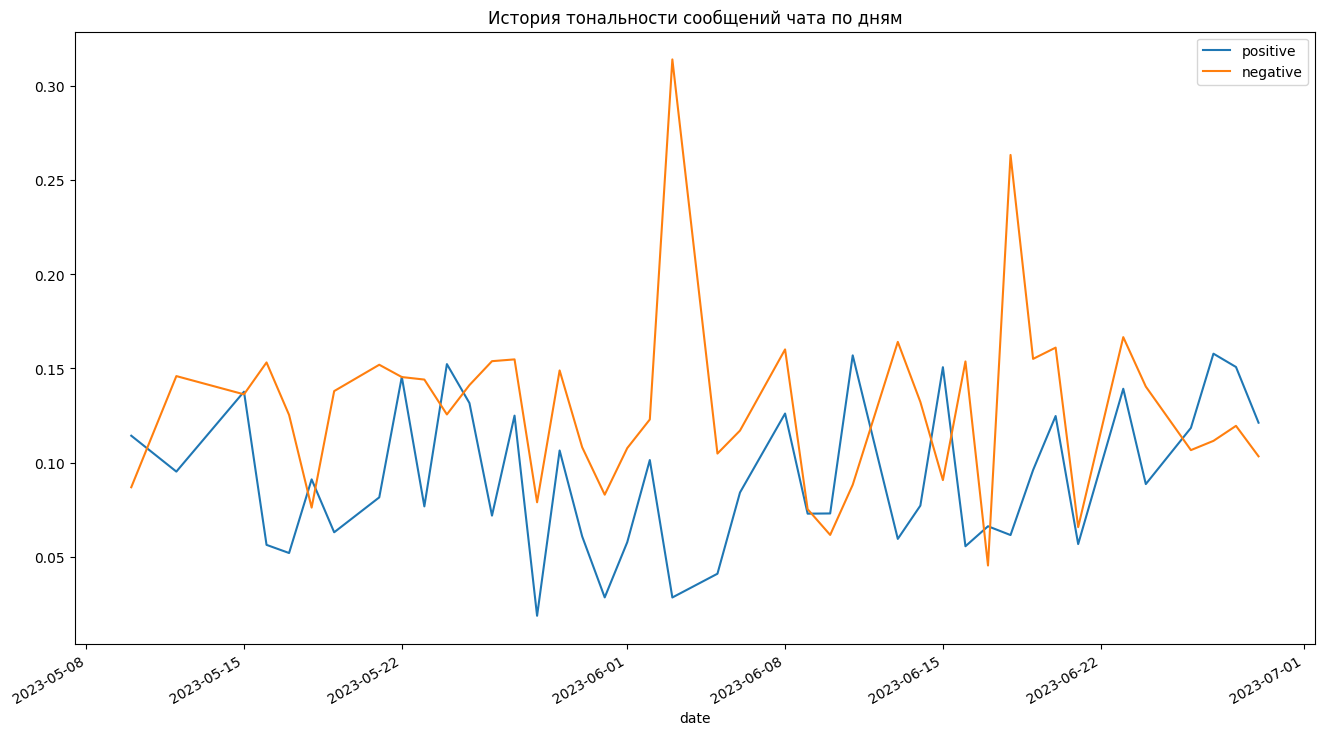

In [ ]:
plt.figure(figsize = (16, 9))

plt.title('История тональности сообщений чата по дням')

df_sentiment_day_resample.positive.plot()
df_sentiment_day_resample.negative.plot()
plt.legend()

plt.plot()

In [ ]:
for text in df_sentiment.set_index('date')['2023-06-03':'2023-06-04'].text:
  print(text)

6го надо быть. Я задачку ещё не открывал, но уже предвкушаю вопросы об расшифровки данных
Будет не по задаче. Просто вебинар вводный
А по задачке вы тогда собирались не записывали? Я в пути был, не смог присоединиться
Видел только блокнот итоговый скидывали, но я завтра тот ко открою все найду время и силы.
Не записывали. Если что, задавай вопросы
Я буду, если успею вернуться из-за границы.


In [ ]:
for text in df_sentiment.set_index('date')['2023-06-18':'2023-06-19'].text:
  print(text)

Друзья, с дискордом появились проблемы.
Собрания на нем проводиться больше не будут. 
Стримы будут либо прямо тут, в телеграмме, либо на платформе Google meets. Это гораздо проще и никуда не нужно регистрироваться :)
Ну, наверное. Случились разногласия с владельцем канала
Оказывается, некоторые люди в сообществе наплевали на совместную работу и развитие и просто зазвездились
Всем привет🔥🔥🔥

Предлагаю в течение следующей недели созваниваться и решать тот датасет, который был на созвоне. Задача - взять метрику 0,97 на лидерборде. Это очень хорошая практика будет для повышения скиллов в машинном обучении. 

Мое решение со стрима вышло 0.93. Вам нужно побить это 🤯

Дедлайнов нет. Все вопросы по коду принимаю. Нужна помощь - обращайтесь 👋🏻
Всем привет! Никто не пробовал этот курс от Гугл за 1 дрллар? Поделитесь отзывами, если есть
привет. Когда говорят, что с нуля до первой должности меньше, чем за 6 месяцев, то это просто маркетинг
Тем более на английском обучение будет проблемно, если не 

# Самые негативные пользователи

In [ ]:
df_sentiment.head()

,date,text,user,neutral,negative,skip,positive,speech
id,,,,,,,,
-999874125,2023-05-07 12:55:46,"Еще раз всем привет🔥\n\nЭта беседа нужна, чтоб...",Данила,0.600198,0.245095,0.103759,0.058356,0.013233
-999874124,2023-05-07 12:56:35,Сейчас я занят подготовкой курса по data scien...,Данила,0.754925,0.206904,0.067557,0.075868,0.003955
-999873962,2023-05-08 00:09:52,"Книга для тех, кто решил погрузится в статисти...",Данила,0.622469,0.239359,0.053413,0.112805,0.015435
-999873715,2023-05-10 21:14:12,Кто-нибудь сидит на код-варсе? Хотел предложит...,zub,0.731069,0.050341,0.334599,0.010338,0.001109
-999873625,2023-05-10 22:13:39,там можно баттл устраивать?) \n\nя там сидел п...,Данила,0.615098,0.033096,0.060097,0.085109,0.002333


In [ ]:
df_user_gr = df_sentiment.groupby('user').agg({'negative':'mean', 'positive':'mean', 'text':'count'})
df_user_gr = df_user_gr[df_user_gr.text>10]
df_user_gr.head(10)

,negative,positive,text
user,,,
Al ex,0.171263,0.062787,26
Andrew B,0.088871,0.078804,25
Data Drive 👨🏻‍💻,0.161240,0.078763,12
Evgeniy,0.151969,0.071393,17
Ivan Nesterov,0.111460,0.024705,14
Julia,0.130703,0.133335,35
Maks,0.168819,0.098798,32
Natalia Horsehealer,0.162514,0.047161,13
Nikita,0.144098,0.111957,18


In [ ]:
df_user_gr.sort_values('negative', ascending=False).head(10)

,negative,positive,text
user,,,
Oxana bashusha,0.193269,0.062811,13
iva,0.189308,0.046695,19
Vadim,0.184115,0.099031,142
Al ex,0.171263,0.062787,26
Maks,0.168819,0.098798,32
Сергей Гарбузов,0.166568,0.105870,74
Natalia Horsehealer,0.162514,0.047161,13
Data Drive 👨🏻‍💻,0.161240,0.078763,12
Алена Баталова,0.152197,0.072937,29


In [ ]:
df_user_gr.sort_values('positive', ascending=False).head(10)

,negative,positive,text
user,,,
Polina,0.103339,0.231041,19
Тигра,0.147236,0.192384,78
Valeriy,0.123697,0.152423,142
Julia,0.130703,0.133335,35
Nikita,0.144098,0.111957,18
lu,0.129768,0.107967,29
Сергей Гарбузов,0.166568,0.105870,74
Vadim,0.184115,0.099031,142
Maks,0.168819,0.098798,32


In [ ]:
df_user_gr.sort_values('text', ascending=False).head(10)

,negative,positive,text
user,,,
Данила,0.119282,0.090891,604
Vadim,0.184115,0.099031,142
Valeriy,0.123697,0.152423,142
Тигра,0.147236,0.192384,78
Сергей Гарбузов,0.166568,0.105870,74
Julia,0.130703,0.133335,35
Maks,0.168819,0.098798,32
Алена Баталова,0.152197,0.072937,29
lu,0.129768,0.107967,29


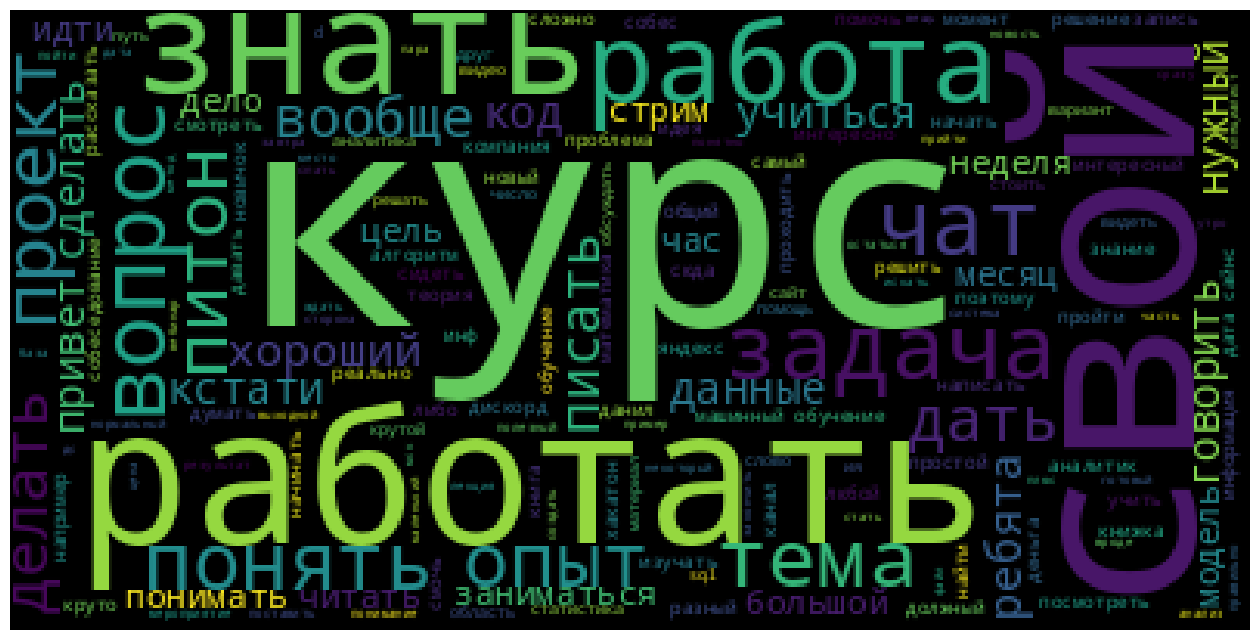

In [ ]:
all_content = ' '.join(df_sentiment.set_index('date').text.to_list())

lemmatizer = pymorphy2.MorphAnalyzer()

def lemmatize_text(tokens):
    text_new=''
    for word in tokens:
        word = lemmatizer.parse(word)
        text_new = text_new + ' ' + word[0].normal_form
    return text_new

text = word_tokenize(all_content)
text = lemmatize_text(text)

#mask = np.array(Image.open('../../plane.jpg'))
stop_words = stop_words.get_stop_words('russian')

cloud = WordCloud(stopwords=stop_words, contour_width=10, contour_color='#AAAAAA').generate(text)
plt.figure(figsize=(16,9))
plt.imshow(cloud)
plt.axis('off')
plt.show()